# Семинар/ДЗ №2: введение в нейронные сети

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from typing import Callable, Any
import tqdm.auto as tqdm

seed = 47
np.random.seed(seed)

%matplotlib inline

## Загружаем выборку Diamonds

Описание данных:

1. **PRICE**: price in US dollars (326-18,823)
2. **CARAT**: weight of the diamond (0.2--5.01)
3. **CUT**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. **COLOR**: diamond colour, from J (worst) to D (best)
5. **CLARITY**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. **X**: length in mm (0--10.74)
7. **Y**: width in mm (0--58.9)
8. **Z**: depth in mm (0--31.8)
9. **DEPTH**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. **TABLE**: width of top of diamond relative to widest point (43--95)

Скачиваем данные с гугл-диска:


In [ ]:
!gdown "10DwRuHOTWWFm3DXXok7vad0vKgzRp7pS"

Downloading...
From: https://drive.google.com/uc?id=10DwRuHOTWWFm3DXXok7vad0vKgzRp7pS
To: /content/diamonds.csv
100% 3.19M/3.19M [00:00<00:00, 87.8MB/s]


In [ ]:
df = pd.read_csv('/content/diamonds.csv').drop(columns=['Unnamed: 0'])
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## Подготовка данных и их анализ

Преобразуем категориальные признаки

In [ ]:
categorial_features = ['cut', 'clarity', 'color']

ct = ColumnTransformer(
       transformers=[
           ('ordinal', OrdinalEncoder(), categorial_features)
       ],
       remainder='passthrough',
       verbose_feature_names_out=False
   )

encoded = ct.fit_transform(df)
df = pd.DataFrame(encoded, columns=ct.get_feature_names_out())
df

,cut,clarity,color,carat,depth,table,price,x,y,z
0,2.0,3.0,1.0,0.23,61.5,55.0,326.0,3.95,3.98,2.43
1,3.0,2.0,1.0,0.21,59.8,61.0,326.0,3.89,3.84,2.31
2,1.0,4.0,1.0,0.23,56.9,65.0,327.0,4.05,4.07,2.31
3,3.0,5.0,5.0,0.29,62.4,58.0,334.0,4.20,4.23,2.63
4,1.0,3.0,6.0,0.31,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,2.0,2.0,0.0,0.72,60.8,57.0,2757.0,5.75,5.76,3.50
53936,1.0,2.0,0.0,0.72,63.1,55.0,2757.0,5.69,5.75,3.61
53937,4.0,2.0,0.0,0.70,62.8,60.0,2757.0,5.66,5.68,3.56
53938,3.0,3.0,4.0,0.86,61.0,58.0,2757.0,6.15,6.12,3.74


In [ ]:
ct.transformers_[0]

('ordinal', OrdinalEncoder(), ['cut', 'clarity', 'color'])

In [ ]:
ct.transformers_[0][1].categories_

[array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object),
 array(['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'],
       dtype=object),
 array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)]

Анализ полученных данных

In [ ]:
def get_pretty_title(text: str) -> str:
    return ('\033[1m' + text + '\033[0m').center(55)

def pretty_print(text: str, values: Any):
    print(f'\n\n{get_pretty_title(text)}', values, sep='\n\n')

def analysis(data: pd.DataFrame,
             target_name: str,
             numerical_features: list[str]):

    pretty_print('Типы данных:', data.dtypes)
    pretty_print('Описательные статистики:', data.describe())
    pretty_print('Пропуски в данных:', data.isna().sum())
    pretty_print('Количество дубликатов:', data.duplicated().sum())

    print(f'\n\n{get_pretty_title("Распределение целевой переменной")}\n')

    plt.figure(figsize=[6, 5])
    plt.hist(df[target_name], bins=100)
    plt.grid()
    plt.show()

In [ ]:
target = ['price']
numerical_features = [col
                      for col in list(df.columns)
                      if col not in categorial_features + target]
numerical_features

['carat', 'depth', 'table', 'x', 'y', 'z']



                  Типы данных:                 

cut        float64
clarity    float64
color      float64
carat      float64
depth      float64
table      float64
price      float64
x          float64
y          float64
z          float64
dtype: object


            Описательные статистики:           

                cut       clarity         color         carat         depth  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       2.553003      3.835150      2.594197      0.797940     61.749405   
std        1.027708      1.724591      1.701105      0.474011      1.432621   
min        0.000000      0.000000      0.000000      0.200000     43.000000   
25%        2.000000      2.000000      1.000000      0.400000     61.000000   
50%        2.000000      4.000000      3.000000      0.700000     61.800000   
75%        3.000000      5.000000      4.000000      1.040000     62.500000   
max        4.000000      7.000000      6.000000      5.010000 

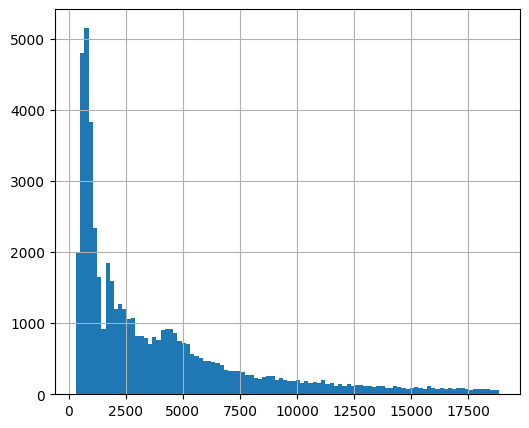

In [ ]:
analysis(df, target_name=target[0], numerical_features=numerical_features)

In [ ]:
df = df.drop_duplicates()

In [ ]:
X = df.drop(columns=target).copy().values
y = df[target].copy().values

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.3)

In [ ]:
X_train.shape

(37655, 9)

In [ ]:
y_train.shape

(37655, 1)

## Обучаем модель линейной регрессии

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
score = r2_score(y_pred, y_test)

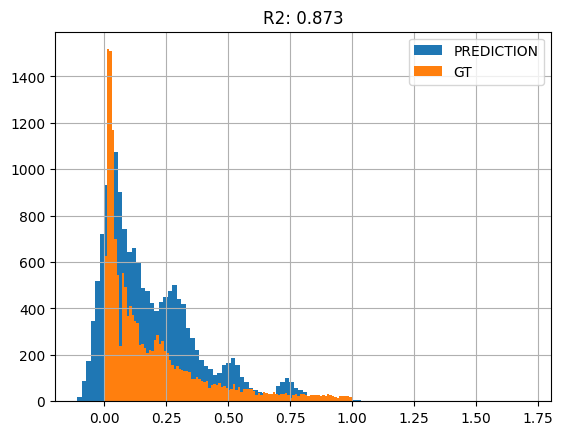

In [ ]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

Посмотрим, как справится нейронная сеть

## Задание 1: реализация слоев нейронной сети (3 балла)

Реализуйте следующие слои:


1.   Линейный слой (1 балл)
2.   Функция активации: ReLU (1 балл)
3.   Функция активации: Tanh (1 балл)

В линейном слое на методы прямого и обратных проходов навешаны декораторы: они понадобятся для следующего задания.



In [ ]:

Rclass Module:
    """
    Базовый класс для построения модулей нейронной сети.

    Attributes:
        forward_hook (Callable): Функция, которая будет вызываться после
                                 вычисления прямого прохода.

        backward_hook (Callable): Функция, которая будет вызываться после
                                  вычисления обратного прохода.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных модулей нейронной сети, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self):
        self.forward_hook = None
        self.backward_hook = None

    def register_forward_hook(self, forward_hook: Callable):
        """
        Метод для регистрации forward_hook
        """

        self.forward_hook = forward_hook

    def register_backward_hook(self, backward_hook: Callable):
        """
        Метод для регистрации backward_hook
        """

        self.backward_hook = backward_hook

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Метод для прямого прохода

        Args:
            x (np.ndarray): Входные данные. Размерность может быть (batch_size,
              in_features) или (in_features,) для вектора.

        Returns:
            np.ndarray: Выходные данные после линейного преобразования
            (размерность: (batch_size, out_features) или (out_features,) для вектора).
        """
        pass

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Метод для обратного прохода

        Args:
            gradient (np.ndarray): Градиент ошибки, полученный от следующего слоя.
            Размерность может быть (batch_size, out_features) или (out_features,)
            для вектора.

        Returns:
            np.ndarray: Градиент ошибки для предыдущего слоя
            (размерность: (batch_size, in_features) или (in_features,) для вектора).
        """
        pass

    def update(self, learning_rate: float) -> None:
        """
        Метод для обновления параметров модуля

        Args:
            learning_rate (float): Скорость обучения.
        """
        pass

Функции для расчета стандартного отклонения при прямом и обратных проходах

In [ ]:
def forward_hook(input_, output):
    std = input_.std().item()
    print('forward', std)

def backward_hook(grad_input, grad_output):
    std = grad_input.std().item()
    print('\tbackward', std)

def execute_hook(hook: Callable) -> Callable:
    def decorator(func: Callable) -> Callable:
        def wrapper(self, x: Any) -> Any:
            output = func(self, x)
            hook(x, output)
            return output
        return wrapper
    return decorator

In [ ]:
class Linear(Module):
    """
    Реализует полносвязный линейный слой.

    Этот слой выполняет линейное преобразование входных данных: y = xW + b,
    где W - матрица весов, b - вектор смещения, а x - входные данные.

    Args:
        in_features (int): Количество входных признаков.
        out_features (int): Количество выходных признаков.
    """

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.bias = None
        self.weight = None

        self.dweight = None
        self.dbias = None
        self.input = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return x @ self.weight + self.bias


    def backward(self, gradient: np.ndarray) -> np.ndarray:
        dx = gradient @ self.weight.T
        self.dweight = self.input.T @ gradient
        self.dbias = np.sum(gradient, axis=0, keepdims=True)
        return dx


    def update(self, learning_rate: float) -> None:
        self.weight -= learning_rate * self.dweight
        self.bias -= learning_rate * self.dbias

In [ ]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        self.input = None


    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.maximum(0, x)


    def backward(self, gradient: np.ndarray) -> np.ndarray:
        drelu = np.where(self.input > 0, 1, 0)
        return gradient * drelu

In [ ]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
        self.output = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.output = np.tanh(x)
        return self.output

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        dtanh = 1 - self.output**2
        return gradient * dtanh

In [ ]:
class LeakyReLU(Module):
    def __init__(self, alpha=1e-2):
        self.alpha = alpha
        self.input = None

    def forward(self, x: np.ndarray):
        self.input = x
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, gradient: np.ndarray):
        dleakyrelu = np.where(self.input > 0, 1, self.alpha)
        return gradient * dleakyrelu

In [ ]:
class ELU(Module):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.input = None

    def forward(self, x):
        self.input = x
        return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))

    def backward(self, dout):
        delu = np.where(self.input > 0, 1, self.alpha * np.exp(self.input))
        return dout * delu

## Задание 2: начальная инициализация (3 балла)

Необходимо реализовать следующие подходы к иницализации нейронной сети:

1. Инициализация случайными числами из нормального распределения (1 балл)
$$\mathbb{N}(0, \frac{1}{n_{in}})$$


2. Инициализация Xavier Glorot (1 балл)
$$U \left[ - \frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}  \right ] $$


3. Инициализация Kaiming He (1 балл)
$$\mathbb{N}(0, \frac{2}{n_{in}})$$



In [ ]:
def init_layer(layer: Module) -> None:
    """
    Инициализирует веса и смещение.

    Args:
        layer (Linear): Экземпляр слоя, который необходимо инициализировать.

    Returns:
        None. Функция изменяет слой layer in-place.
    """
    layer.weight = np.random.randn(layer.in_features, layer.out_features)
    layer.bias = np.zeros((1, layer.out_features))

In [ ]:
def random_init(layer: Module):
    std_dev = np.sqrt(1.0 / layer.in_features)
    weight = np.random.normal(0, std_dev, size=(layer.in_features, layer.out_features))

    layer.weight = weight
    layer.bias = np.zeros((1, layer.out_features))

In [ ]:
def xavier_init(layer: Module):
    limit = np.sqrt(6.0 / (layer.in_features + layer.out_features))
    weight = np.random.uniform(-limit, limit, size=(layer.in_features, layer.out_features))

    layer.weight = weight
    layer.bias = np.zeros((1, layer.out_features))

In [ ]:
def kaiming_he_init(layer: Module) -> None:
    std_dev = np.sqrt(2.0 / layer.in_features)
    weight = np.random.normal(0, std_dev, size=(layer.in_features, layer.out_features))

    layer.weight = weight
    layer.bias = np.zeros((1, layer.out_features))

## Задание 3: MLP для задачи регрессии (4 балла)

Необходимо реализовать модель MLP для задачи регресcии

Для визуализации процесса обучения рекомендуется использовать модуль `tqdm`

In [ ]:
class Sequential:
    """
    Класс, представляющий из себя 'конструктор' для нейросети.
    Слои добавляются в порядке, в котором затем будут вызваны для прямого прохода
    Args:
        layers (list): Список слоев нейросети
    """
    def __init__(self, *layers):
        if layers:
            self.layers = list(layers)
        else:
            self.layers = []

    def forward(self, x):
        """
        Прямой проход
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, gradient):
        """
        Обратный проход
        """
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def update(self, learning_rate):
        """
        Обновление весов линейных слоев
        """
        for layer in self.layers:
            if hasattr(layer, 'update'):
                layer.update(learning_rate)

    def add_layer(self, layer):
        """
        Добавление нового слоя в конец нейросети
        """
        self.layers.append(layer)

In [ ]:
class MSELoss:
    """
    Класс MSE для подсчета ошибки
    """
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean((y_pred - y_true) ** 2)

    def backward(self):
        return 2 * (self.y_pred - self.y_true) / self.y_pred.shape[0]

In [ ]:
mse_loss = MSELoss()

In [ ]:
class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, grad_output):
        return grad_output

    def update(self, g):
        pass

In [ ]:
class CrossEntropy:
    def __init__(self):
        self.true_labels = None
        self.pred_probs = None

    def forward(self, pred_probs, true_labels):
        self.true_labels = true_labels
        self.pred_probs = pred_probs
        pred_probs = np.clip(pred_probs, 1e-15, 1 - 1e-15)
        loss = -np.sum(true_labels * np.log(pred_probs)) / pred_probs.shape[0]
        return loss

    def backward(self):
        grad_output = (self.pred_probs - self.true_labels) / self.pred_probs.shape[0]
        return grad_output

In [ ]:
class MLPRegressor:
    """
    Класс MLP для задач регрессии.

    Attributes:
        init_func (function): Функция инициализации весов слоев.
            Принимает на вход слой и производит его инициализацию.
        hidden_layer_sizes (tuple): Размеры скрытых слоев.
        batch_size (int): Размер батча при обучении.
        learning_rate (float, optional): Скорость обучения.
        max_iter (int): Максимальное количество эпох обучения.
    """
    def __init__(
            self,
            init_func: Callable,
            batch_size: int,
            learning_rate: float,
            max_iter: int,
            # Список слоев
            layers: list[Module]
        ):

        self.init_func = init_func
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        self.layers = layers
        self.model = Sequential()

        # Переменная для дальнейшего создания графика Loss
        self.losses = []


    def __customize_layer(self, layer):
        """
        Настраивает слой перед добавлением в модель.

        Регистрирует хуки прямого и обратного прохода, а также инициализирует
        веса слоя с помощью self.init_func.

        Args:
            layer (Module): Слой для настройки.

        Returns:
            Module: Настроенный слой.
        """

        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        self.init_func(layer)
        return layer

    def setup_model(self):
        """
        Настройка модели
        """
        for layer in self.layers:
            if isinstance(layer, Linear):
                linear_layer = self.__customize_layer(layer)
                self.model.add_layer(linear_layer)
            else:
                self.model.add_layer(layer)


    def train(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Обучает модель на заданных данных.

        Args:
            X (np.ndarray): Матрица входных данных.
            y (np.ndarray): Матрица целевых значений.
        """

        for epoch in tqdm.tqdm(range(self.max_iter)):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_train_shuffled = X[indices]
            y_train_shuffled = y[indices]

            for i in range(0, X_train.shape[0], self.batch_size):
                X_batch = X_train_shuffled[i:i + self.batch_size]
                y_batch = y_train_shuffled[i:i + self.batch_size]

                y_pred = self.model.forward(X_batch)

                loss = mse_loss.forward(y_pred, y_batch)

                grad = mse_loss.backward()
                self.model.backward(grad)

                self.model.update(self.learning_rate)

            y_pred_val = self.model.forward(X_test)
            loss = mse_loss.forward(y_pred_val, y_test)
            self.losses.append(loss)

            print(f"Epoch [{epoch + 1}/{self.max_iter}], Loss: {loss:.4f}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Делает предсказание на заданных входных данных.

        Args:
            X (np.ndarray): Матрица входных данных.

        Returns:
            np.ndarray: Матрица предсказанных значений.
        """

        y_pred = self.model.forward(X)

        return y_pred

Проверяем модель MLP на выборке Diamonds

##Модель с двумя скрытыми слоями и функцией активации ReLU:

In [ ]:
layers = [
    Linear(9, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 2),
    ReLU(),
    Softmax()
]

mlp_regressor = MLPRegressor(kaiming_he_init, 64, 0.02, 200, layers=layers)
mlp_regressor.setup_model()
mse_loss = MSELoss()
mlp_regressor.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0072
Epoch [2/200], Loss: 0.0063
Epoch [3/200], Loss: 0.0059
Epoch [4/200], Loss: 0.0052
Epoch [5/200], Loss: 0.0048
Epoch [6/200], Loss: 0.0045
Epoch [7/200], Loss: 0.0043
Epoch [8/200], Loss: 0.0041
Epoch [9/200], Loss: 0.0040
Epoch [10/200], Loss: 0.0039
Epoch [11/200], Loss: 0.0037
Epoch [12/200], Loss: 0.0036
Epoch [13/200], Loss: 0.0036
Epoch [14/200], Loss: 0.0035
Epoch [15/200], Loss: 0.0044
Epoch [16/200], Loss: 0.0034
Epoch [17/200], Loss: 0.0034
Epoch [18/200], Loss: 0.0033
Epoch [19/200], Loss: 0.0033
Epoch [20/200], Loss: 0.0032
Epoch [21/200], Loss: 0.0033
Epoch [22/200], Loss: 0.0032
Epoch [23/200], Loss: 0.0039
Epoch [24/200], Loss: 0.0033
Epoch [25/200], Loss: 0.0031
Epoch [26/200], Loss: 0.0031
Epoch [27/200], Loss: 0.0032
Epoch [28/200], Loss: 0.0031
Epoch [29/200], Loss: 0.0031
Epoch [30/200], Loss: 0.0031
Epoch [31/200], Loss: 0.0030
Epoch [32/200], Loss: 0.0030
Epoch [33/200], Loss: 0.0030
Epoch [34/200], Loss: 0.0030
Epoch [35/200], Loss: 0

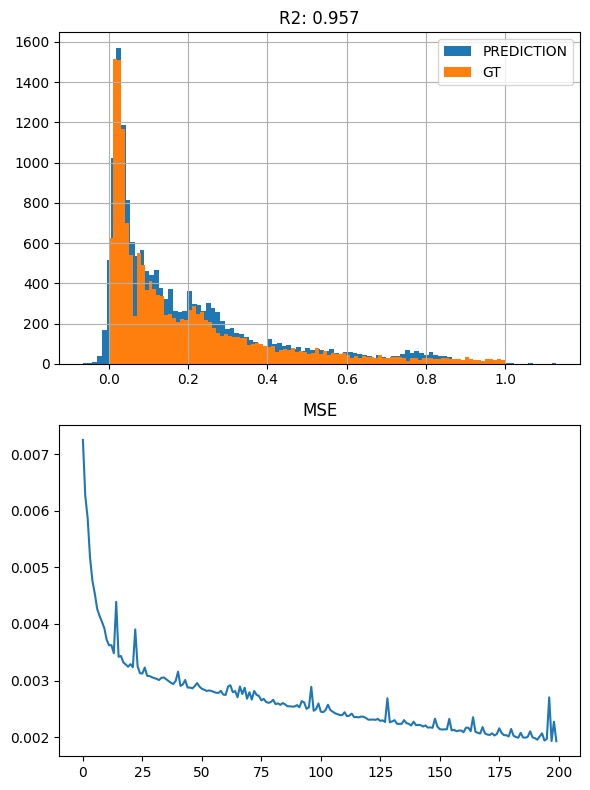

In [ ]:
mlp_regressor.predict(X_test)

##Модель с двумя скрытыми слоями, но более "широкая"

In [ ]:
layers_2_wide = [
    Linear(9, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 1),
]

mlp_regressor_2_layer_wide = MLPRegressor(kaiming_he_init, 64, 0.02, 200, layers=layers_2_wide)
mlp_regressor_2_layer_wide.setup_model()
mlp_regressor_2_layer_wide.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0080
Epoch [2/200], Loss: 0.0054
Epoch [3/200], Loss: 0.0048
Epoch [4/200], Loss: 0.0060
Epoch [5/200], Loss: 0.0041
Epoch [6/200], Loss: 0.0039
Epoch [7/200], Loss: 0.0040
Epoch [8/200], Loss: 0.0072
Epoch [9/200], Loss: 0.0038
Epoch [10/200], Loss: 0.0035
Epoch [11/200], Loss: 0.0093
Epoch [12/200], Loss: 0.0037
Epoch [13/200], Loss: 0.0037
Epoch [14/200], Loss: 0.0033
Epoch [15/200], Loss: 0.0036
Epoch [16/200], Loss: 0.0034
Epoch [17/200], Loss: 0.0060
Epoch [18/200], Loss: 0.0031
Epoch [19/200], Loss: 0.0031
Epoch [20/200], Loss: 0.0038
Epoch [21/200], Loss: 0.0032
Epoch [22/200], Loss: 0.0032
Epoch [23/200], Loss: 0.0031
Epoch [24/200], Loss: 0.0031
Epoch [25/200], Loss: 0.0033
Epoch [26/200], Loss: 0.0031
Epoch [27/200], Loss: 0.0030
Epoch [28/200], Loss: 0.0030
Epoch [29/200], Loss: 0.0052
Epoch [30/200], Loss: 0.0030
Epoch [31/200], Loss: 0.0048
Epoch [32/200], Loss: 0.0029
Epoch [33/200], Loss: 0.0029
Epoch [34/200], Loss: 0.0030
Epoch [35/200], Loss: 0

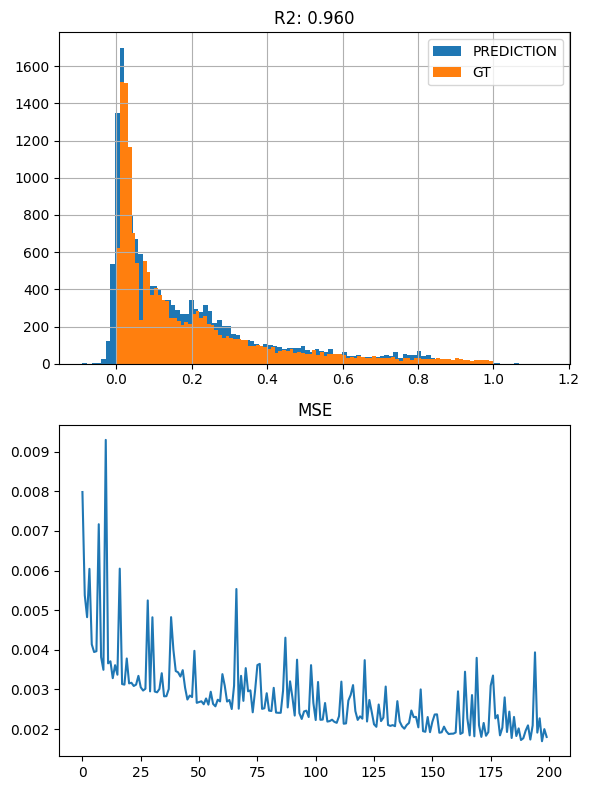

In [ ]:
mlp_regressor_2_layer_wide.predict(X_test)

##Модель с тремя скрытыми слоями и активацией ReLU:

In [ ]:
relu_3_layers = [
    Linear(9, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 16),
    ReLU(),
    Linear(16, 1)
]

mlp_regressor_3_layers = MLPRegressor(kaiming_he_init, 64, 0.02, 200, layers=relu_3_layers)
mlp_regressor_3_layers.setup_model()
mlp_regressor_3_layers.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0063
Epoch [2/200], Loss: 0.0049
Epoch [3/200], Loss: 0.0046
Epoch [4/200], Loss: 0.0042
Epoch [5/200], Loss: 0.0041
Epoch [6/200], Loss: 0.0047
Epoch [7/200], Loss: 0.0040
Epoch [8/200], Loss: 0.0041
Epoch [9/200], Loss: 0.0038
Epoch [10/200], Loss: 0.0037
Epoch [11/200], Loss: 0.0036
Epoch [12/200], Loss: 0.0036
Epoch [13/200], Loss: 0.0035
Epoch [14/200], Loss: 0.0035
Epoch [15/200], Loss: 0.0038
Epoch [16/200], Loss: 0.0036
Epoch [17/200], Loss: 0.0034
Epoch [18/200], Loss: 0.0035
Epoch [19/200], Loss: 0.0034
Epoch [20/200], Loss: 0.0034
Epoch [21/200], Loss: 0.0033
Epoch [22/200], Loss: 0.0033
Epoch [23/200], Loss: 0.0042
Epoch [24/200], Loss: 0.0033
Epoch [25/200], Loss: 0.0033
Epoch [26/200], Loss: 0.0032
Epoch [27/200], Loss: 0.0039
Epoch [28/200], Loss: 0.0032
Epoch [29/200], Loss: 0.0031
Epoch [30/200], Loss: 0.0031
Epoch [31/200], Loss: 0.0032
Epoch [32/200], Loss: 0.0031
Epoch [33/200], Loss: 0.0032
Epoch [34/200], Loss: 0.0031
Epoch [35/200], Loss: 0

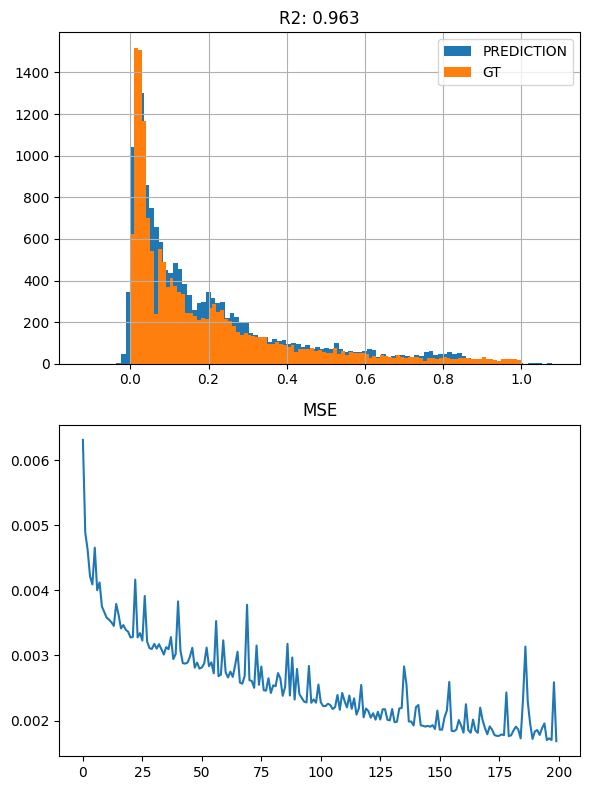

In [ ]:
mlp_regressor_3_layers.predict(X_test)

##Модель с тремя слоями и активацией ReLU, но модель "шире"

In [ ]:
relu_wide_layers = [
    Linear(9, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 16),
    ReLU(),
    Linear(16, 1),
]

mlp_regressor_3_layers_wide = MLPRegressor(kaiming_he_init, 64, 0.02, 200, layers=relu_wide_layers)
mlp_regressor_3_layers_wide.setup_model()
mlp_regressor_3_layers_wide.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0072
Epoch [2/200], Loss: 0.0057
Epoch [3/200], Loss: 0.0046
Epoch [4/200], Loss: 0.0041
Epoch [5/200], Loss: 0.0037
Epoch [6/200], Loss: 0.0040
Epoch [7/200], Loss: 0.0034
Epoch [8/200], Loss: 0.0040
Epoch [9/200], Loss: 0.0033
Epoch [10/200], Loss: 0.0033
Epoch [11/200], Loss: 0.0031
Epoch [12/200], Loss: 0.0030
Epoch [13/200], Loss: 0.0030
Epoch [14/200], Loss: 0.0030
Epoch [15/200], Loss: 0.0029
Epoch [16/200], Loss: 0.0032
Epoch [17/200], Loss: 0.0029
Epoch [18/200], Loss: 0.0029
Epoch [19/200], Loss: 0.0029
Epoch [20/200], Loss: 0.0036
Epoch [21/200], Loss: 0.0054
Epoch [22/200], Loss: 0.0030
Epoch [23/200], Loss: 0.0028
Epoch [24/200], Loss: 0.0027
Epoch [25/200], Loss: 0.0027
Epoch [26/200], Loss: 0.0027
Epoch [27/200], Loss: 0.0027
Epoch [28/200], Loss: 0.0030
Epoch [29/200], Loss: 0.0027
Epoch [30/200], Loss: 0.0029
Epoch [31/200], Loss: 0.0026
Epoch [32/200], Loss: 0.0027
Epoch [33/200], Loss: 0.0030
Epoch [34/200], Loss: 0.0026
Epoch [35/200], Loss: 0

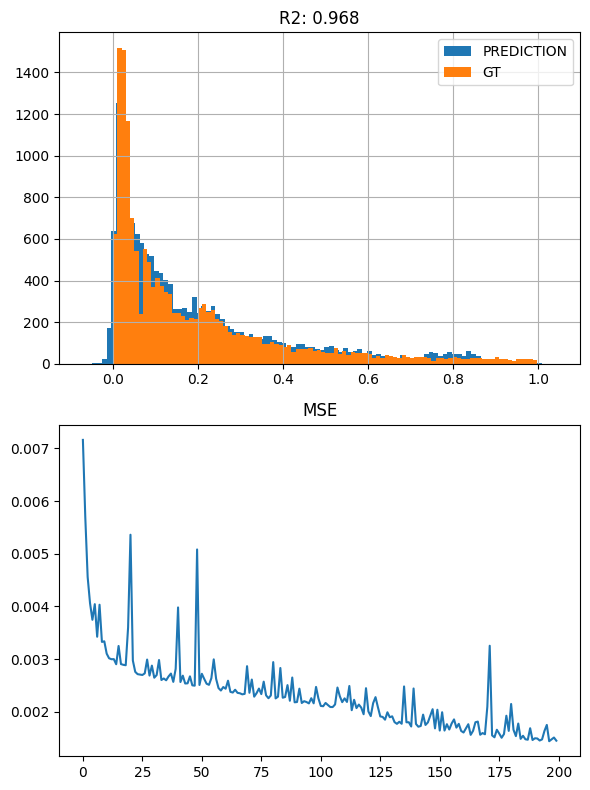

In [ ]:
mlp_regressor_3_layers_wide.predict(X_test)

##Широкая модель с активацией Leaky ReLU (Просто ради интереса):

In [ ]:
leaky_relu_layers = [
    Linear(9, 128),
    LeakyReLU(),
    Linear(128, 64),
    LeakyReLU(),
    Linear(64, 32),
    LeakyReLU(),
    Linear(32, 1)
]

mlp_regressor_leaky = MLPRegressor(kaiming_he_init, 64, 0.01, 200, layers=leaky_relu_layers)
mlp_regressor_leaky.setup_model()
mlp_regressor_leaky.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0071
Epoch [2/200], Loss: 0.0053
Epoch [3/200], Loss: 0.0046
Epoch [4/200], Loss: 0.0042
Epoch [5/200], Loss: 0.0040
Epoch [6/200], Loss: 0.0038
Epoch [7/200], Loss: 0.0036
Epoch [8/200], Loss: 0.0037
Epoch [9/200], Loss: 0.0037
Epoch [10/200], Loss: 0.0034
Epoch [11/200], Loss: 0.0033
Epoch [12/200], Loss: 0.0033
Epoch [13/200], Loss: 0.0033
Epoch [14/200], Loss: 0.0033
Epoch [15/200], Loss: 0.0032
Epoch [16/200], Loss: 0.0032
Epoch [17/200], Loss: 0.0033
Epoch [18/200], Loss: 0.0031
Epoch [19/200], Loss: 0.0031
Epoch [20/200], Loss: 0.0031
Epoch [21/200], Loss: 0.0031
Epoch [22/200], Loss: 0.0031
Epoch [23/200], Loss: 0.0030
Epoch [24/200], Loss: 0.0031
Epoch [25/200], Loss: 0.0030
Epoch [26/200], Loss: 0.0030
Epoch [27/200], Loss: 0.0030
Epoch [28/200], Loss: 0.0030
Epoch [29/200], Loss: 0.0030
Epoch [30/200], Loss: 0.0030
Epoch [31/200], Loss: 0.0029
Epoch [32/200], Loss: 0.0029
Epoch [33/200], Loss: 0.0030
Epoch [34/200], Loss: 0.0029
Epoch [35/200], Loss: 0

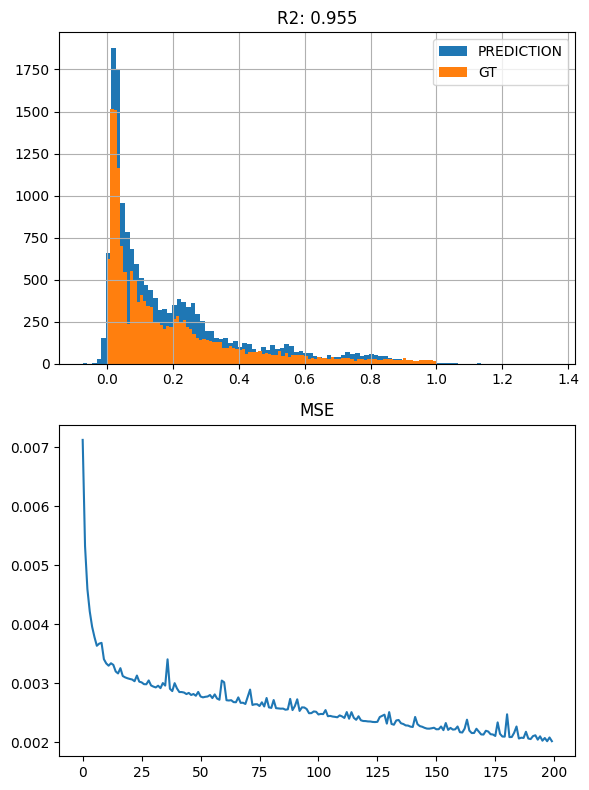

In [ ]:
mlp_regressor_leaky.predict(X_test)

##Широкая модель с 4 скрытыми слоям:

In [ ]:
layers_4 = [
    Linear(9, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 16),
    ReLU(),
    Linear(16, 1)
]

model_4_layers = MLPRegressor(kaiming_he_init, 64, 0.02, 200, layers=layers_4)
model_4_layers.setup_model()
model_4_layers.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0056
Epoch [2/200], Loss: 0.0044
Epoch [3/200], Loss: 0.0040
Epoch [4/200], Loss: 0.0038
Epoch [5/200], Loss: 0.0037
Epoch [6/200], Loss: 0.0036
Epoch [7/200], Loss: 0.0035
Epoch [8/200], Loss: 0.0034
Epoch [9/200], Loss: 0.0033
Epoch [10/200], Loss: 0.0032
Epoch [11/200], Loss: 0.0033
Epoch [12/200], Loss: 0.0032
Epoch [13/200], Loss: 0.0031
Epoch [14/200], Loss: 0.0031
Epoch [15/200], Loss: 0.0031
Epoch [16/200], Loss: 0.0030
Epoch [17/200], Loss: 0.0031
Epoch [18/200], Loss: 0.0030
Epoch [19/200], Loss: 0.0035
Epoch [20/200], Loss: 0.0032
Epoch [21/200], Loss: 0.0029
Epoch [22/200], Loss: 0.0029
Epoch [23/200], Loss: 0.0029
Epoch [24/200], Loss: 0.0029
Epoch [25/200], Loss: 0.0028
Epoch [26/200], Loss: 0.0028
Epoch [27/200], Loss: 0.0028
Epoch [28/200], Loss: 0.0031
Epoch [29/200], Loss: 0.0028
Epoch [30/200], Loss: 0.0032
Epoch [31/200], Loss: 0.0027
Epoch [32/200], Loss: 0.0027
Epoch [33/200], Loss: 0.0027
Epoch [34/200], Loss: 0.0027
Epoch [35/200], Loss: 0

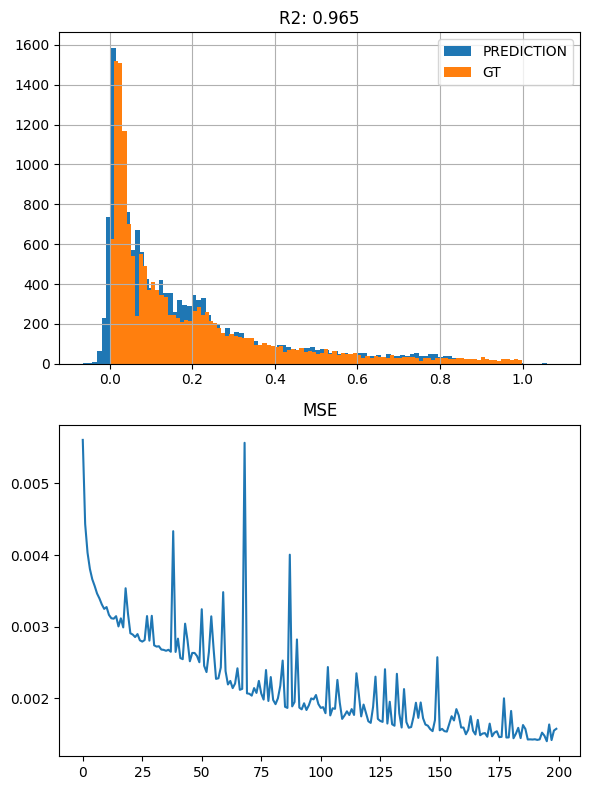

In [ ]:
model_4_layers.predict(X_test)

##Из моделей с активацией ReLU модели с тремя скрытыми слоями себя показывают лучше, чем с двумя. Значит, в наших данных есть достаточно сложые отношения, которые модель с тремя слоями лучше "улавливает". Подтвердить это может и тот факт, что та же модель с тремя более широкими скрытыми слоями справилась даже слегка лучше. Однако само обучение происходит медленнее. Четвертый слой улучшений не принес. Скорее всего, 3 скрытых слоя для данной задачи это оптимальная кофигурация. Добавлять больше смысла нет
##Активация Leaky ReLU по факту ничего не дала. Скорее всего это из-за того, что в данных нет отрицатльных значений

##Модель с одним скрытым широким слоем

In [ ]:
layers = [
    Linear(9, 256),
    ReLU(),
    Linear(256, 1)
]

one_layer_mlp_regressor = MLPRegressor(kaiming_he_init, 64, 0.03, 200, layers)
one_layer_mlp_regressor.setup_model()
one_layer_mlp_regressor.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0063
Epoch [2/200], Loss: 0.0053
Epoch [3/200], Loss: 0.0048
Epoch [4/200], Loss: 0.0043
Epoch [5/200], Loss: 0.0045
Epoch [6/200], Loss: 0.0039
Epoch [7/200], Loss: 0.0037
Epoch [8/200], Loss: 0.0036
Epoch [9/200], Loss: 0.0036
Epoch [10/200], Loss: 0.0034
Epoch [11/200], Loss: 0.0034
Epoch [12/200], Loss: 0.0033
Epoch [13/200], Loss: 0.0037
Epoch [14/200], Loss: 0.0032
Epoch [15/200], Loss: 0.0033
Epoch [16/200], Loss: 0.0032
Epoch [17/200], Loss: 0.0031
Epoch [18/200], Loss: 0.0031
Epoch [19/200], Loss: 0.0031
Epoch [20/200], Loss: 0.0031
Epoch [21/200], Loss: 0.0030
Epoch [22/200], Loss: 0.0036
Epoch [23/200], Loss: 0.0030
Epoch [24/200], Loss: 0.0030
Epoch [25/200], Loss: 0.0031
Epoch [26/200], Loss: 0.0030
Epoch [27/200], Loss: 0.0030
Epoch [28/200], Loss: 0.0030
Epoch [29/200], Loss: 0.0029
Epoch [30/200], Loss: 0.0028
Epoch [31/200], Loss: 0.0028
Epoch [32/200], Loss: 0.0028
Epoch [33/200], Loss: 0.0028
Epoch [34/200], Loss: 0.0028
Epoch [35/200], Loss: 0

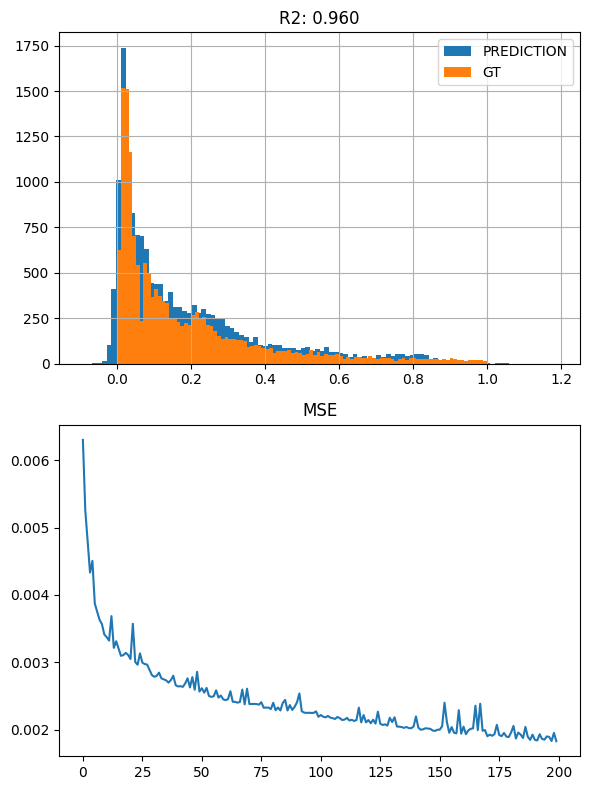

In [ ]:
one_layer_mlp_regressor.predict(X_test)

##Интересно, что модель с одним скрытым широким слоем справилась лучше, чем модель с двумя менее широкими скрытыми слоями и также, как модель с двумя скрытыми широкими слоями.

##Попробуем сделать модель с двумя скрытыми слоями, которые сделаем очень широкими:

In [ ]:
layers = [
    Linear(9, 512),
    ReLU(),
    Linear(512, 256),
    ReLU(),
    Linear(256, 1)
]

two_layer_mlp_regressor = MLPRegressor(kaiming_he_init, 64, 0.03, 100, layers)
two_layer_mlp_regressor.setup_model()
two_layer_mlp_regressor.train(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.0063
Epoch [2/100], Loss: 0.0053
Epoch [3/100], Loss: 0.0052
Epoch [4/100], Loss: 0.0041
Epoch [5/100], Loss: 0.0037
Epoch [6/100], Loss: 0.0033
Epoch [7/100], Loss: 0.0034
Epoch [8/100], Loss: 0.0042
Epoch [9/100], Loss: 0.0030
Epoch [10/100], Loss: 0.0030
Epoch [11/100], Loss: 0.0035
Epoch [12/100], Loss: 0.0031
Epoch [13/100], Loss: 0.0028
Epoch [14/100], Loss: 0.0030
Epoch [15/100], Loss: 0.0028
Epoch [16/100], Loss: 0.0027
Epoch [17/100], Loss: 0.0032
Epoch [18/100], Loss: 0.0036
Epoch [19/100], Loss: 0.0026
Epoch [20/100], Loss: 0.0036
Epoch [21/100], Loss: 0.0045
Epoch [22/100], Loss: 0.0026
Epoch [23/100], Loss: 0.0036
Epoch [24/100], Loss: 0.0025
Epoch [25/100], Loss: 0.0026
Epoch [26/100], Loss: 0.0025
Epoch [27/100], Loss: 0.0024
Epoch [28/100], Loss: 0.0024
Epoch [29/100], Loss: 0.0024
Epoch [30/100], Loss: 0.0027
Epoch [31/100], Loss: 0.0028
Epoch [32/100], Loss: 0.0026
Epoch [33/100], Loss: 0.0024
Epoch [34/100], Loss: 0.0027
Epoch [35/100], Loss: 0

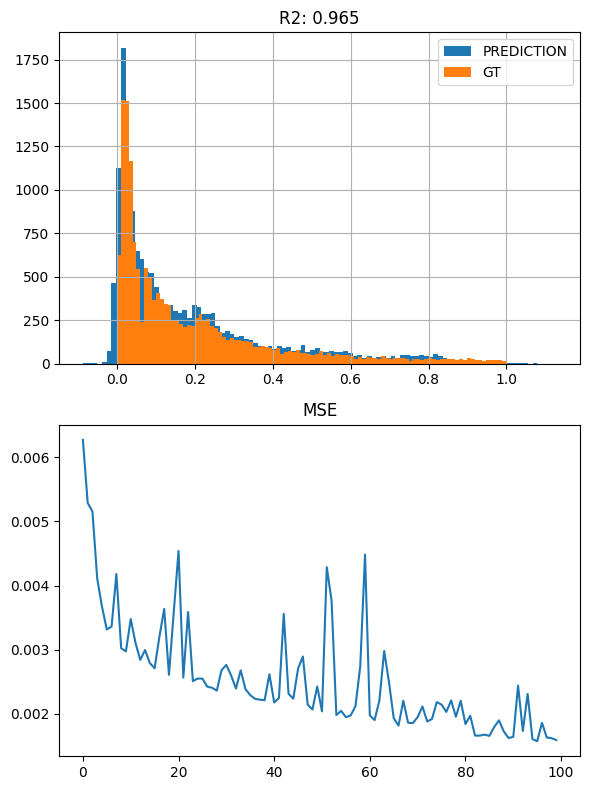

In [ ]:
two_layer_mlp_regressor.predict(X_test)

#Она справилась почти также, как и модель с тремя скрытыми менее широкими слоями и ровно также, как модель с 4 слоями. Возможно, для нашего простого датасета подходят модели с меньшим количеством слоев. Однако стоит отметить, что такие "широкие" модели обучаются крайне медленно. На порядок медленнее, чем более глубокие модели, поэтому я бы не назвал такой подход оптимальным.

##Возьмем лучшую на данный момент модель и поставим инициализацию xavier:

In [ ]:
relu_wide_layers = [
    Linear(9, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 16),
    ReLU(),
    Linear(16, 1),
]

mlp_regressor_3_layers_wide = MLPRegressor(xavier_init, 64, 0.02, 200, layers=relu_wide_layers)
mlp_regressor_3_layers_wide.setup_model()
mlp_regressor_3_layers_wide.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0064
Epoch [2/200], Loss: 0.0046
Epoch [3/200], Loss: 0.0040
Epoch [4/200], Loss: 0.0035
Epoch [5/200], Loss: 0.0033
Epoch [6/200], Loss: 0.0032
Epoch [7/200], Loss: 0.0032
Epoch [8/200], Loss: 0.0032
Epoch [9/200], Loss: 0.0030
Epoch [10/200], Loss: 0.0031
Epoch [11/200], Loss: 0.0029
Epoch [12/200], Loss: 0.0029
Epoch [13/200], Loss: 0.0033
Epoch [14/200], Loss: 0.0029
Epoch [15/200], Loss: 0.0028
Epoch [16/200], Loss: 0.0028
Epoch [17/200], Loss: 0.0028
Epoch [18/200], Loss: 0.0027
Epoch [19/200], Loss: 0.0027
Epoch [20/200], Loss: 0.0028
Epoch [21/200], Loss: 0.0027
Epoch [22/200], Loss: 0.0027
Epoch [23/200], Loss: 0.0027
Epoch [24/200], Loss: 0.0028
Epoch [25/200], Loss: 0.0027
Epoch [26/200], Loss: 0.0027
Epoch [27/200], Loss: 0.0026
Epoch [28/200], Loss: 0.0026
Epoch [29/200], Loss: 0.0026
Epoch [30/200], Loss: 0.0026
Epoch [31/200], Loss: 0.0025
Epoch [32/200], Loss: 0.0027
Epoch [33/200], Loss: 0.0026
Epoch [34/200], Loss: 0.0025
Epoch [35/200], Loss: 0

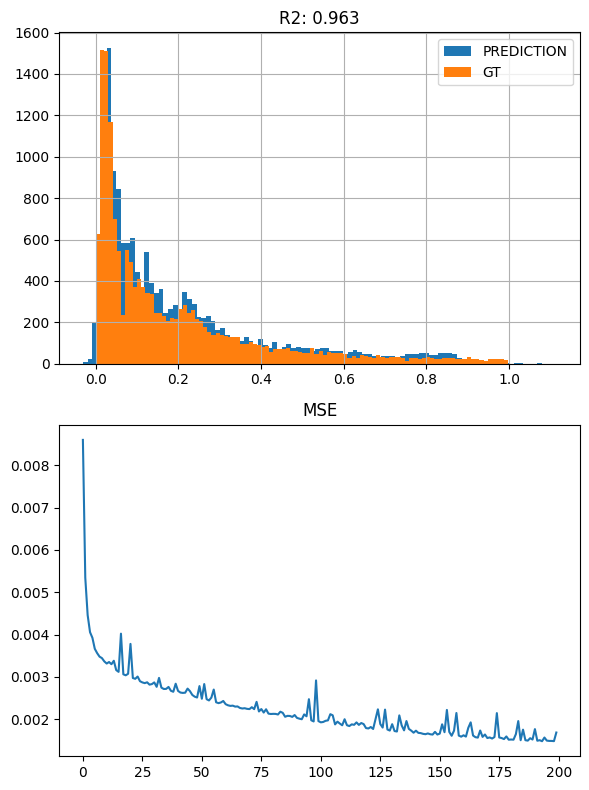

In [ ]:
mlp_regressor_3_layers_wide.predict(X_test)

В данной модели используется активация ReLU, для которой лучше подходит инициализация kaiming, потому что она учитывает специфику этой функции и решает проблему исчезающей дисперсии, вызванной обнуление отрицательных значений. Однако в нашем датасете во время обучения, как я полагаю, мало отрицательных значений, и инициализация xavier работает почти также.

##Модель с 3 широкими слоями и активацией Tanh

In [ ]:
tanh_wide_layers = [
    Linear(9, 128),
    Tanh(),
    Linear(128, 64),
    Tanh(),
    Linear(64, 16),
    Tanh(),
    Linear(16, 1),
]

mlp_regressor_tanh = MLPRegressor(kaiming_he_init, 64, 0.01, 200, layers=tanh_wide_layers)
mlp_regressor_tanh.setup_model()
mlp_regressor_tanh.train(X_train, y_train)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Loss: 0.0081
Epoch [2/200], Loss: 0.0067
Epoch [3/200], Loss: 0.0066
Epoch [4/200], Loss: 0.0054
Epoch [5/200], Loss: 0.0051
Epoch [6/200], Loss: 0.0058
Epoch [7/200], Loss: 0.0045
Epoch [8/200], Loss: 0.0050
Epoch [9/200], Loss: 0.0052
Epoch [10/200], Loss: 0.0041
Epoch [11/200], Loss: 0.0040
Epoch [12/200], Loss: 0.0039
Epoch [13/200], Loss: 0.0039
Epoch [14/200], Loss: 0.0039
Epoch [15/200], Loss: 0.0037
Epoch [16/200], Loss: 0.0037
Epoch [17/200], Loss: 0.0036
Epoch [18/200], Loss: 0.0035
Epoch [19/200], Loss: 0.0036
Epoch [20/200], Loss: 0.0034
Epoch [21/200], Loss: 0.0034
Epoch [22/200], Loss: 0.0036
Epoch [23/200], Loss: 0.0034
Epoch [24/200], Loss: 0.0042
Epoch [25/200], Loss: 0.0037
Epoch [26/200], Loss: 0.0039
Epoch [27/200], Loss: 0.0037
Epoch [28/200], Loss: 0.0033
Epoch [29/200], Loss: 0.0033
Epoch [30/200], Loss: 0.0037
Epoch [31/200], Loss: 0.0032
Epoch [32/200], Loss: 0.0032
Epoch [33/200], Loss: 0.0037
Epoch [34/200], Loss: 0.0032
Epoch [35/200], Loss: 0

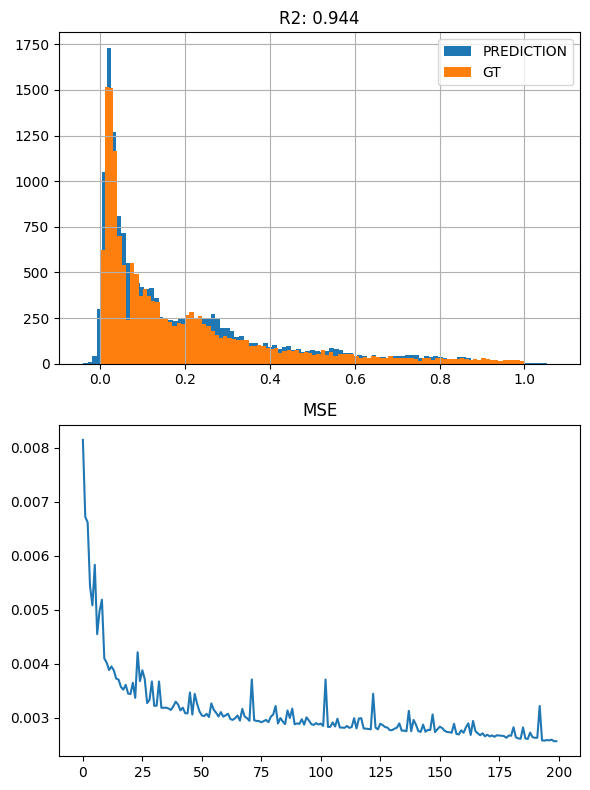

In [ ]:
mlp_regressor_tanh.predict(X_test)

##Во-первых, модель с Tanh активацией работает значительно медленнее ReLU, так вычисление такой функции само по-себе вычислительно дороже из-за экспоненты. Во-вторых, такая активация оказалось менее эффективной, чем ReLU. ReLU выдает положительные активации без каких-либо ограничений (в том смысле, что значение Tanh ограничено между -1 и 1, а положительные значения функции ReLU ничем не ограничены), что делает его очень подходящим для зачачи регрессии, в которой мы определяем цену товара, ведь цена не может быть отрицательной. Активация Tanh в свою очередь ограничена межде значениями -1 и 1, это ограничивает возможность модели предсказывать значение цены.

# Домашнее задание № 2

Выполните задания в этом ноутбуке, а также:

1. Сравните подходы к начальной инициализации весов нейронной сети. В качестве ответа ожидается текстовое описание проведенного анализа и полученных выводов.

    *Подсказка: с помощью предложенных декораторов понаблюдайте за выходами слоев при обучении как при прямом, так и при обратном проходах. Удобнее это сделать на одном линейном слое.*

2. Сравните различные архитектуры моделей, экспериментируйте с размерами
слоев, их количеством, функциями активации, а также подходами к инициализации и гиперпараметрами. Подберите лучшую связку, дающую наивысшую целевую метрику.

    В качестве ответа приведите описание проведенных вами экспериментов и выводы из них *(не обязательно, чтобы все эксперименты были удачными, нужно чтобы из каждого был извлечен полезный опыт)*

ВАЖНО: при отсутствии анализа (только за реализацию) баллы не начисляются.

+ Мягкий дедлайн: `05.02.25 23:59`
+ Жесткий дедлайн: `12.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.